# Recomendación de productos a clientes

En este notebook creamos un modelo de recomendación de productos basado en el filtrado colaborativo. El filtrado colaborativo basado en clientes sugiere productos a un usuario en función de las preferencias y comportamientos de usuarios similares. En este contexto, utilizamos los clientes de almacen que son los únicos que están diferenciados en la base de datos inicial. La idea principal detrás del filtrado colaborativo basado en clientes es que si un usuario A tiene preferencias similares a las de un usuario B, entonces las recomendaciones de productos que le gustan a B podrían interesarle a A.

In [1]:
#Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from surprise import Dataset, Reader
from surprise import accuracy
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('once')

In [2]:
tienda = pd.read_csv('tienda.csv')
tipos_de_datos = {
    'ID_PRODUCTO': 'object',
    'FECHA_COMPRA': 'datetime64[ns]',
    'CADUCIDAD': 'datetime64[ns]',
    'CANTIDAD': 'float64',
    'PRECIO_TOTAL': 'float64',
    'INDEX_CLIENTES': 'int32',
    'ETIQUETA_CANAL': 'int64',
    'CATEGORIA': 'object',
}
tienda = tienda.astype(tipos_de_datos)
tienda = tienda.loc[tienda['CANTIDAD'] >= 0]
tienda['mes'] = tienda['FECHA_COMPRA'].dt.month
tienda['semana'] = tienda['FECHA_COMPRA'].dt.isocalendar().week
tienda.head()

,ID_PRODUCTO,FECHA_COMPRA,CADUCIDAD,CANTIDAD,PRECIO_TOTAL,INDEX_CLIENTES,ETIQUETA_CANAL,CATEGORIA,mes,semana
0,00026751,2023-07-29,2023-08-01,1.00,8.33,0,1,Salchichon i embutidos,7,30
1,00026751,2023-07-08,2023-10-01,0.59,4.94,5,1,Salchichon i embutidos,7,27
2,00026751,2023-07-08,2023-10-01,0.35,2.93,5,1,Salchichon i embutidos,7,27
3,00026751,2023-07-08,2023-10-01,0.32,2.64,5,1,Salchichon i embutidos,7,27
4,00026751,2023-07-09,2023-10-01,1.20,10.04,5,1,Salchichon i embutidos,7,27


## Nuevo dataframe de clientes

In [3]:
clientes = tienda[tienda['ETIQUETA_CANAL']== 3]
clientes = clientes.drop('CADUCIDAD', axis=1)
clientes['MES'] = clientes['FECHA_COMPRA'].dt.month

In [4]:
clientes.head()

,ID_PRODUCTO,FECHA_COMPRA,CANTIDAD,PRECIO_TOTAL,INDEX_CLIENTES,ETIQUETA_CANAL,CATEGORIA,mes,semana,MES
143,00026751,2023-09-12,0.21,2.05,56,3,Salchichon i embutidos,9,37,9
144,00026751,2023-08-01,0.09,0.75,58,3,Salchichon i embutidos,8,31,8
145,00026751,2023-09-26,0.16,1.55,58,3,Salchichon i embutidos,9,39,9
146,00026751,2023-08-14,0.44,3.13,92,3,Salchichon i embutidos,8,33,8
148,00001019,2023-07-11,1.00,0.90,2,3,Agua y refrescos,7,28,7


## Creamos el modelo - KNN (k-nearest neighbors)

#### ¿Por qué este modelo?

- KNN se utiliza para capturar la similitud entre usuarios basándose en su comportamiento pasado. Al encontrar usuarios que tienen preferencias similares a un usuario dado, el sistema puede hacer recomendaciones que sean relevantes para ese usuario.
- KNN es un algoritmo simple y fácil de entender.
- KNN es adaptable a cambios en el comportamiento del usuario.
- KNN es capaz de manejar eficientemente datos esparsos y hacer recomendaciones incluso en situaciones donde solo hay una pequeña cantidad de interacciones conocidas.
- KNN permite una personalización significativa, ya que las recomendaciones se generan específicamente para cada usuario basándose en sus vecinos más cercanos.

In [5]:
# Utilizamos Reader para hacer un rating de los clientes utilizando la cantidad comprada.
# Tiene que haber hecho como minimo una compra para estar en el rating.
# Cargamos los datos en un nuevo datafame utilizando la libreria Surprise (Surprise es una biblioteca de Python diseñada específicamente para trabajar con sistemas de recomendación).
reader = Reader(rating_scale=(1, clientes['CANTIDAD'].max()))
data = Dataset.load_from_df(clientes[['INDEX_CLIENTES', 'ID_PRODUCTO', 'CANTIDAD']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Crear un modelo de filtrado colaborativo basado en usuarios (KNN)
model = KNNBasic(sim_options={'user_based': True})
model.fit(trainset)
predictions = model.test(testset)

# Buscamos el error del modelo
accuracy.rmse(predictions)
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]
r2 = r2_score(y_true, y_pred)
print("R^2:", r2)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 24.0376
R^2: 0.3177143166551102


### Probamos el modelo con un cliente

In [6]:
# Hacer recomendaciones para un cliente específico (por ejemplo, cliente_id = 1)
cliente_id = 1
productos_recomendados = clientes['ID_PRODUCTO'].unique()
productos_no_comprados = clientes[clientes['INDEX_CLIENTES'] != cliente_id]['ID_PRODUCTO'].unique()

recomendaciones = []
for producto in productos_no_comprados:
    pred = model.predict(cliente_id, producto)
    recomendaciones.append((producto, pred.est))

recomendaciones = sorted(recomendaciones, key=lambda x: x[1], reverse=True)
top_recomendaciones = recomendaciones[:5]
print("Top 5 recomendaciones para el cliente {}: {}".format(cliente_id, top_recomendaciones))

Top 5 recomendaciones para el cliente 1: [('00006120', 424.0), ('00010252', 180.0), ('00024338', 172.78643078903696), ('00000051', 160.0), ('00025976', 80.0)]


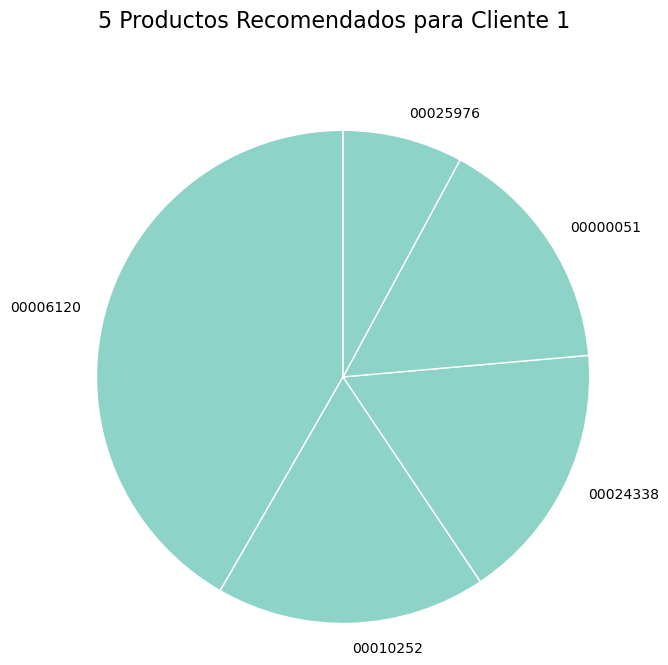

In [7]:
recomendaciones_cliente_1 = [('00006120', 424.0), ('00010252', 180.0), ('00024338', 172.78643078903696), ('00000051', 160.0), ('00025976', 80.0)]
fig, ax = plt.subplots(figsize=(7, 7))
colores_clientes = sns.color_palette('Set3', n_colors=1)
productos, calificaciones = zip(*recomendaciones_cliente_1)
ax.pie(calificaciones, labels=productos, startangle=90, colors=colores_clientes, wedgeprops=dict(linewidth=1, edgecolor='white'))
ax.axis('equal')
plt.subplots_adjust(hspace=0.5)
plt.suptitle('5 Productos Recomendados para Cliente 1', fontsize=16, y=1.02)

plt.show()

### Probamos el modelo con los TOP 10 clientes

In [8]:
top_10_clientes = clientes.groupby('INDEX_CLIENTES')['CANTIDAD'].sum().nlargest(10).index

for cliente_id in top_10_clientes:
    productos_no_comprados = clientes[clientes['INDEX_CLIENTES'] == cliente_id]['ID_PRODUCTO'].unique()
    recomendaciones = []
    for producto in productos_no_comprados:
        calificacion_estimada = clientes[clientes['ID_PRODUCTO'] == producto]['CANTIDAD'].mean()
        recomendaciones.append((producto, calificacion_estimada))
    recomendaciones = sorted(recomendaciones, key=lambda x: x[1], reverse=True)
    top_recomendaciones = recomendaciones[:5]
    print("Top 5 recomendaciones para el cliente {}: {}".format(cliente_id, top_recomendaciones))

Top 5 recomendaciones para el cliente 25: [('00021009', 79.85714285714286), ('00015706', 58.53846153846154), ('00005536', 57.0), ('00015708', 54.747058823529414), ('00193868', 48.22222222222222)]
Top 5 recomendaciones para el cliente 85: [('00026897', 249.3846153846154), ('00026898', 203.58823529411765), ('00024338', 156.0), ('00027204', 156.0), ('00027202', 112.0)]
Top 5 recomendaciones para el cliente 124: [('00025711', 53.166666666666664), ('00025710', 49.0), ('00193868', 48.22222222222222), ('00026345', 35.714285714285715), ('00025682', 35.4)]
Top 5 recomendaciones para el cliente 9: [('00015706', 58.53846153846154), ('08000504', 57.25), ('00015708', 54.747058823529414), ('00193868', 48.22222222222222), ('00015707', 45.5886524822695)]
Top 5 recomendaciones para el cliente 59: [('00025716', 94.125), ('00014969', 92.2), ('00014509', 74.6), ('00023381', 72.5), ('00025975', 70.0)]
Top 5 recomendaciones para el cliente 77: [('00026897', 249.3846153846154), ('00026898', 203.5882352941176

In [9]:
recomendaciones_clientes = {
    25: [('00021009', 79.85714285714286), ('00015706', 57.41772151898734), ('00015708', 53.76162790697674), ('00193868', 48.22222222222222), ('00005536', 48.111111111111114)],
    85: [('00026897', 249.3846153846154), ('00026898', 203.58823529411765), ('00024338', 156.0), ('00027204', 156.0), ('00027202', 112.0)],
    124: [('00025711', 53.166666666666664), ('00025710', 49.0), ('00193868', 48.22222222222222), ('00026345', 35.714285714285715), ('00025682', 35.4)],
    9: [('00015706', 57.41772151898734), ('08000504', 57.25), ('00015708', 53.76162790697674), ('00193868', 48.22222222222222), ('00015707', 44.84507042253521)],
    59: [('00025716', 94.125), ('00014969', 75.0), ('00014509', 74.6), ('00023381', 72.5), ('00025975', 70.0)],
    77: [('00026897', 249.3846153846154), ('00026898', 203.58823529411765), ('00024652', 60.0), ('00015706', 57.41772151898734), ('00026534', 53.411764705882355)],
    4: [('00006120', 424.0), ('00026897', 249.3846153846154), ('00026898', 203.58823529411765), ('00024338', 156.0), ('00001471', 105.66666666666667)],
    22: [('00005452', 30.548387096774192), ('00008725', 28.25), ('00193806', 24.018450184501845), ('00008122', 23.448160535117058), ('C0000135', 21.177570093457945)],
    15: [('00015706', 57.41772151898734), ('08000504', 57.25), ('00015708', 53.76162790697674), ('00015707', 44.84507042253521), ('00022167', 35.38461538461539)],
    66: [('00021009', 79.85714285714286), ('00014509', 74.6), ('00193868', 48.22222222222222), ('00001579', 30.11111111111111), ('00014020', 29.818181818181817)],
}

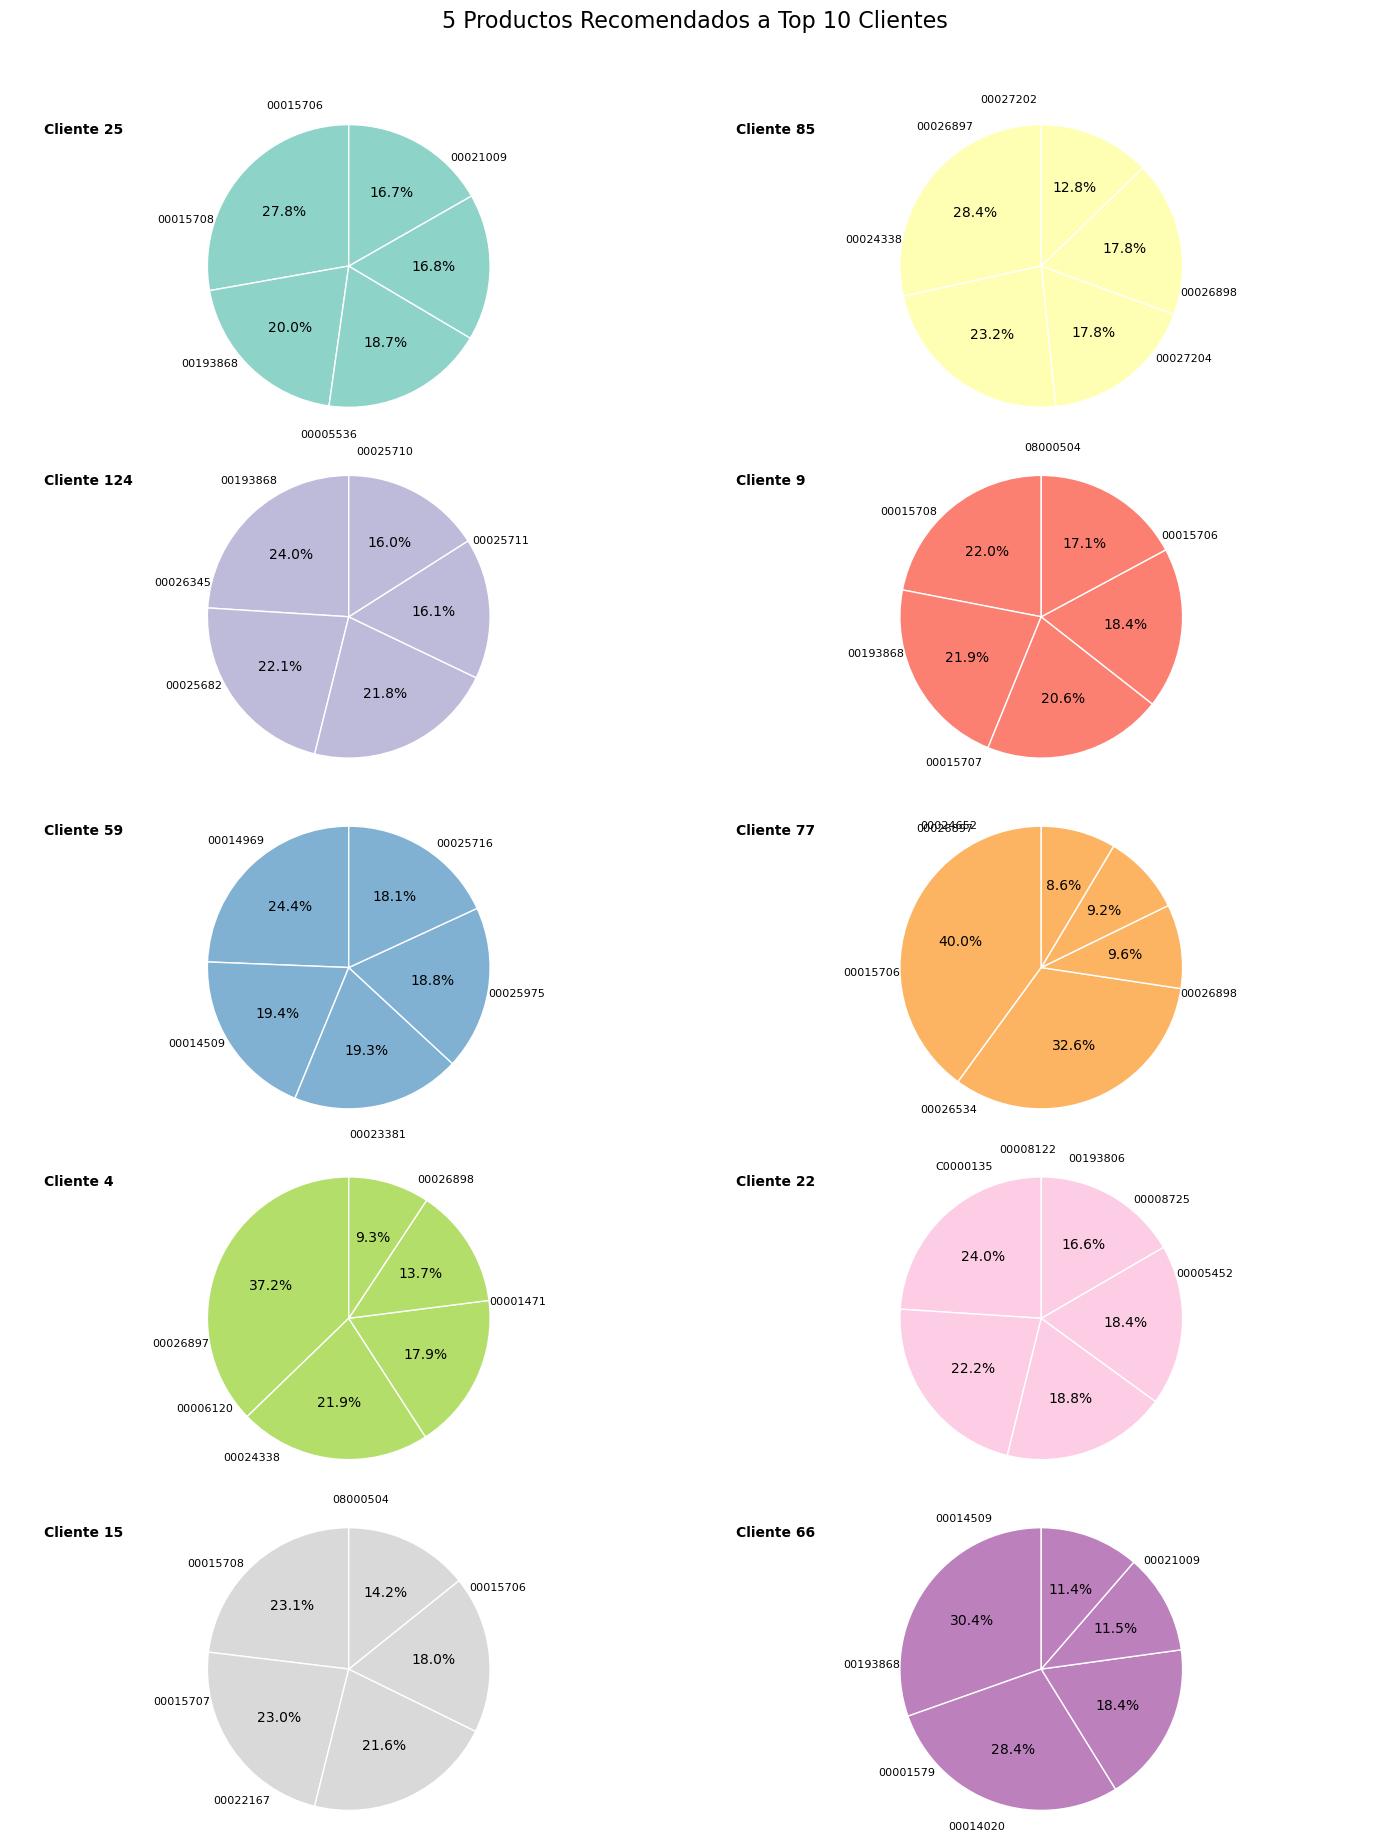

In [10]:
fig, axs = plt.subplots(5, 2, figsize=(14, 18))  # 5 filas, 2 columnas para los 10 clientes
axs = axs.flatten()
colores_clientes = sns.color_palette('Set3', n_colors=len(recomendaciones_clientes))
for i, (cliente_id, recomendaciones) in enumerate(recomendaciones_clientes.items()):
    productos, calificaciones = zip(*recomendaciones)
    axs[i].pie(calificaciones, labels=None, autopct='%1.1f%%', startangle=90, colors=[colores_clientes[i]], wedgeprops=dict(linewidth=1, edgecolor='white'))
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    axs[i].set_title('Cliente {}'.format(cliente_id), loc='left', fontsize=10, weight='bold', y=0.9, x=0.05)
    for j, (producto, calificacion) in enumerate(recomendaciones):
        angle = sum(calificaciones[:j]) + calificacion / 2
        x = 1.2 * np.cos(np.radians(angle))
        y = 1.2 * np.sin(np.radians(angle))
        # Evitar superposición de etiquetas entre sí y con el título
        if j > 0 and (np.abs(angle - sum(calificaciones[:j])) < 10 or np.linalg.norm(np.array([x, y])) < 0.5):
            x = 1.5 * np.cos(np.radians(angle))
            y = 1.5 * np.sin(np.radians(angle))
        axs[i].text(x, y, producto, ha='center', va='center', fontsize=8, color='black')

plt.subplots_adjust(hspace=0.5)
plt.suptitle('5 Productos Recomendados a Top 10 Clientes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Conclusiones

Nuestro modelo de k-nearest neighbors (KNN) con un RMSE de 24.0376 y un R^2 de 0.3177, da un error alto que se podría mejorar teniendo más datos de los clientes para que las relaciones de clientes similares sean más acorde a cada caso. Algunos de los datos que la empresa puede proporcionar para mejorar el modelo sería:
- Información demográfica de cada cliente.
- Datos sociales para saber para que se necesitan los productos.
- Feedback y reseñas de los clientes.
- Recomendaciones de los clientes.
- Categorizar los clientes de tienda física y online.
- Historial de devoluciones.
- Más meses de información de compras para poder mejorar el modelo.
